# Load the Library

In [29]:
import os
from pathlib import Path
import datetime

from tqdm import tqdm
from dataclasses import dataclass, asdict

import polars as pl
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler

# Review the Dataset

In [30]:
import pandas as pd

train = pd.read_csv("/Users/yarusu/Library/CloudStorage/OneDrive-UCSanDiego/DS/SP500ExcessPredictor/train.csv")
test = pd.read_csv("/Users/yarusu/Library/CloudStorage/OneDrive-UCSanDiego/DS/SP500ExcessPredictor/test.csv")

print(train.shape)
print(test.shape)

(8990, 98)
(10, 99)


In [31]:
print(train.columns.tolist)
print(test.columns.tolist)

<bound method IndexOpsMixin.tolist of Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
       'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3',
       'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13',
       'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns',
       'risk_free_rate', 'market_forward_excess_returns'],
      dtype='object')>
<bound method IndexOpsMixin.tolist of Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',

### Dataset Variable Explanation

The dataset contains historical market, macroeconomic, and technical features. Below is a description of the columns:

| Column | Description |
|:-------|:------------|
| `date_id` | Identifier for each trading day |
| `D1`–`D9` | Dummy / binary features |
| `E1`–`E20` | Macroeconomic features |
| `I1`–`I9` | Interest rate related features |
| `M1`–`M18` | Market dynamics / technical features |
| `P1`–`P13` | Price / valuation features |
| `S1`–`S12` | Sentiment features |
| `V1`–`V13` | Volatility features |
| `MOM*` | Momentum features (if present) |
| `forward_returns` | Next-day return of buying S&P 500 index (training set only) |
| `risk_free_rate` | Federal funds rate (training set only) |
| `market_forward_excess_returns` | Excess forward returns relative to expected, winsorized by MAD 4 (training set only) |
| `is_scored` | Indicator whether the sample should be scored/predicted (test set only) |
| `lagged_forward_returns` | Forward return of previous day (test set only) |
| `lagged_risk_free_rate` | Lagged federal funds rate (test set only) |
| `lagged_market_forward_excess_returns` | Lagged excess forward returns (test set only) |

# Configurations

In [32]:
from pathlib import Path
import numpy as np

# PATHS: change this to the folder where train.csv and test.csv are stored locally
DATA_PATH: Path = Path('/Users/yarusu/Library/CloudStorage/OneDrive-UCSanDiego/DS/SP500ExcessPredictor/')

# RETURNS TO SIGNAL CONFIGS: Translates continuous predictions (returns) into practical signals that control position size.
MIN_SIGNAL: float = 0.0                         # Minimum daily trading signal (prevents over-short positions)
MAX_SIGNAL: float = 2.0                         # Maximum daily trading signal (prevents over-long positions)
SIGNAL_MULTIPLIER: float = 400.0                # Factor to scale predicted excess returns into actionable trading signals

# MODEL CONFIGS
CV: int = 10                                    # Number of cross-validation folds
L1_RATIO: float = 0.5                           # Mixing ratio between L1 and L2 regularization
ALPHAS: np.ndarray = np.logspace(-4, 2, 100)    # Candidate values for regularization strength
MAX_ITER: int = 1_000_000                       # Maximum number of iterations to prevent non-convergence

# Dataclasses Helpers

In [33]:
@dataclass
class DatasetOutput:
    X_train : pl.DataFrame
    X_test: pl.DataFrame
    y_train: pl.Series
    y_test: pl.Series
    scaler: StandardScaler

@dataclass
class ElasticNetParameters:
    l1_ratio : float
    cv: int
    alphas: np.ndarray
    max_iter: int

    def __post_init__(self):
        if self.l1_ratio < 0 or self.l1_ratio > 1:
            raise ValueError("Wrong initializing value for ElasticNet l1_ratio")

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL

# Set the Parameters

In [34]:
ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

enet_params = ElasticNetParameters(
    l1_ratio = L1_RATIO,
    cv = CV,
    alphas = ALPHAS,
    max_iter = MAX_ITER
)

# Data Processing

In [35]:
def load_trainset() -> pl.DataFrame:
    """
    Loads and preprocesses the training dataset.

    Returns:
        pl.DataFrame: The preprocessed training DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "train.csv")
        .rename({'market_forward_excess_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        )
        .head(-10)
    )

def load_testset() -> pl.DataFrame:
    """
    Loads and preprocesses the testing dataset.

    Returns:
        pl.DataFrame: The preprocessed testing DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "test.csv")
        .rename({'lagged_forward_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        )
    )

# Creating Helper Functions

Create new features and preprocess the input DataFrame for modeling.

This function performs the following steps:
   1. Creates new derived features (U1 and U2) from existing columns.
   2. Selects a subset of relevant columns for modeling.
   3. Fills missing values in the selected features using exponential weighted moving average (EWMA) to smooth time-series data.
   4. Drops any remaining rows with null values.

In [36]:
def create_example_dataset(df: pl.DataFrame) -> pl.DataFrame:
    vars_to_keep: list[str] = [
        "S2", "E2", "E3", "P9", "S1", "S5", "I2", "P8",
        "P10", "P12", "P13", "V1", "V2"
    ]

    return (
        df.select(["date_id", "target"] + vars_to_keep)
        .with_columns([
            pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5))
            for col in vars_to_keep
        ])
        .drop_nulls()
    )

Merge training and testing DataFrames by keeping only common columns and stacking them vertically to create a single combined dataset.

In [37]:
def join_train_test_dataframes(train: pl.DataFrame, test: pl.DataFrame) -> pl.DataFrame:
    common_columns: list[str] = [col for col in train.columns if col in test.columns]

    # Select only common columns and concatenate the two DataFrames vertically
    return pl.concat(
        [train.select(common_columns), test.select(common_columns)],
        how="vertical"
    )

Prepare the training and testing datasets for modeling by separating features and target, and scaling the feature values.

Steps performed:
   1. Split the input DataFrames into features (X) and target (y).
   2. Drop non-feature columns ('date_id' and 'target').
   3. Scale the feature values using StandardScaler (zero mean, unit variance).
   4. Convert the scaled numpy arrays back to Polars DataFrames, preserving feature names.

In [38]:
def split_dataset(train: pl.DataFrame, test: pl.DataFrame, features: list[str]) -> DatasetOutput:
    # Separate features and target
    X_train = train.drop(['date_id','target'])
    y_train = train.get_column('target')
    X_test = test.drop(['date_id','target'])
    y_test = test.get_column('target')

    # Fit scaler on training features and transform both train and test
    scaler = StandardScaler()
    X_train_scaled_np = scaler.fit_transform(X_train)
    X_train = pl.from_numpy(X_train_scaled_np, schema=features)

    X_test_scaled_np = scaler.transform(X_test)
    X_test = pl.from_numpy(X_test_scaled_np, schema=features)

    # Return all prepared data in a single dataclass
    return DatasetOutput(
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test,
        scaler = scaler
    )

# Converting Return Prediction to Signal

Converts raw model predictions (expected returns) into a trading signal.

In [39]:
def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters
) -> np.ndarray:
    # Scale the predicted returns, shift by 1 to make "no position" as 1,
    # then clip the values to be within the min and max signal bounds
    return np.clip(
        ret_arr * params.signal_multiplier + 1,  # scale & shift
        params.min_signal,                       # minimum allowed signal
        params.max_signal                        # maximum allowed signal
    )

Example:

In [40]:
import numpy as np

predicted_returns = np.array([0.002, -0.001, 0.005])
params = RetToSignalParameters(signal_multiplier=400, min_signal=0, max_signal=2)

signals = convert_ret_to_signal(predicted_returns, params)
print(signals)

[1.8 0.6 2. ]


| Explanation | Signal Value | Meaning |
|-------------|--------------|---------|
| Signal less than 1 indicates a short position; the magnitude shows the strength. | 0.6 | Sell signal (weak short) |
| Signal equal to 1 means no trading action is taken. | 1.0 | No position (neutral) |
| Signal greater than 1 indicates a long position; the magnitude shows the strength. | 1.8 | Buy signal (medium strength long) |
| Signal is clipped at max_signal, representing the strongest allowable long position. | 2.0 | Maximum buy signal (strongest long) |

# Looking at the Data

In [41]:
train: pl.DataFrame = load_trainset()
test: pl.DataFrame = load_testset()
train.head(3)

date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,target
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.002421,0.000301,-0.003038
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.008495,0.000303,-0.009114
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.009624,0.000301,-0.010243


In [42]:
test.head(3)

date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,is_scored,target,lagged_risk_free_rate,lagged_market_forward_excess_returns
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
8980,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.577651,0.186177,0.001323,0.001323,0.001323,0.001323,0.955026,-0.583419,-0.704264,0.298365,-0.691361,1.259065,1.556516,1.71258,0.033069,0.333333,0.036376,-0.046483,-0.312326,0.913029,0.306217,1.025756,0.081349,0.478175,0.675627,0.699735,0.256283,…,-1.427834,0.352513,0.926257,0.431383,-0.476976,0.500245,1.784173,0.029762,0.294719,0.51455,0.446429,0.466551,0.085717,-0.230132,0.272487,-0.106894,0.199735,0.409392,0.532717,0.744048,0.440476,-0.654839,0.699735,0.699074,-0.5024,0.882937,0.892196,0.828042,0.999172,0.759921,-0.803127,0.170966,-0.751909,1.0,0.003541,0.000161,0.003068
8981,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.575182,0.185847,0.000992,0.000992,0.000992,0.000992,0.955357,-0.583074,-0.703759,0.297608,-0.504499,1.193468,1.554184,1.640054,0.032738,0.333003,0.036045,0.073582,-0.312345,0.91336,0.305886,0.989571,0.082672,0.477844,0.661527,0.719577,0.255952,…,-1.37652,0.953042,0.386905,0.523549,-0.421365,-0.234829,1.770175,0.03373,0.304496,0.638228,0.636905,1.849101,0.28169,-0.041995,0.448413,0.094321,0.215608,0.409392,0.597864,0.872354,0.691138,-0.583443,0.62996,0.598545,-0.394268,0.863757,0.699074,0.831349,1.120336,0.556217,-0.686192,0.141865,-0.660326,1.0,-0.005964,0.000162,-0.006437
8982,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.57272,0.185516,0.000661,0.000661,0.000661,0.000661,0.955688,-0.083356,-0.573546,0.225822,-0.393903,1.123361,1.551723,1.562722,0.032407,0.332672,0.035714,0.033581,-0.312364,0.91369,0.291997,1.040514,0.081349,0.477513,0.655741,0.724206,0.22619,…,-1.34762,0.210979,0.635251,-1.138198,-0.494248,-1.042718,1.754171,0.032407,0.257609,0.082011,0.152116,-0.201611,0.346373,0.054032,0.137566,0.294305,0.194444,0.409392,0.596528,0.778439,0.634921,-0.483236,0.669974,0.603836,-0.17042,0.848545,0.647487,0.832672,1.088992,0.665344,-0.459367,0.199405,-0.510979,1.0,-0.00741,0.00016,-0.007882


# Generating the Train and Test

In [43]:
# Join train and test datasets into a single dataframe to ensure consistent preprocessing and feature engineering
df: pl.DataFrame = join_train_test_dataframes(train, test)

# Apply feature selection, missing value handling, or any custom preprocessing
df = create_example_dataset(df=df)

# Split the processed dataframe back into train and test sets using the original date_ids
train: pl.DataFrame = df.filter(pl.col('date_id').is_in(train.get_column('date_id')))
test: pl.DataFrame = df.filter(pl.col('date_id').is_in(test.get_column('date_id')))

# Select feature columns for model training (exclude 'date_id' and target)
FEATURES: list[str] = [col for col in test.columns if col not in ['date_id', 'target']]

# Split datasets into X (features) and y (target), and also get the scaler for standardization
dataset: DatasetOutput = split_dataset(train=train, test=test, features=FEATURES)

# Extract processed features, target, and scaler for convenience
X_train: pl.DataFrame = dataset.X_train
X_test: pl.DataFrame = dataset.X_test
y_train: pl.DataFrame = dataset.y_train
y_test: pl.DataFrame = dataset.y_test
scaler: StandardScaler = dataset.scaler

/var/folders/tq/h1v27n6j66s05lq52_nhqd8h0000gn/T/ipykernel_57136/516552350.py:8: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  train: pl.DataFrame = df.filter(pl.col('date_id').is_in(train.get_column('date_id')))
/var/folders/tq/h1v27n6j66s05lq52_nhqd8h0000gn/T/ipykernel_57136/516552350.py:9: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  test: pl.DataFrame = df.filter(pl.col('date_id').is_in(test.get_column('date_id')))


# Fitting the Model

In [44]:
# Find the optimal alpha using cross-validation
model_cv: ElasticNetCV = ElasticNetCV(
    **asdict(enet_params)
)
model_cv.fit(X_train, y_train)

# Fit the final model using the best alpha found by cross-validation
model: ElasticNet = ElasticNet(alpha=model_cv.alpha_, l1_ratio=enet_params.l1_ratio)
model.fit(X_train, y_train)

ElasticNet(alpha=0.0003053855508833416)

# Prediction Function

In [45]:
def predict(test: pl.DataFrame) -> float:
    test = test.rename({'lagged_forward_returns':'target'})
    df: pl.DataFrame = create_example_dataset(test)
    X_test: pl.DataFrame = df.select(FEATURES)
    X_test_scaled_np: np.ndarray = scaler.transform(X_test)
    X_test: pl.DataFrame = pl.from_numpy(X_test_scaled_np, schema=FEATURES)
    raw_pred: float = model.predict(X_test)[0]
    return convert_ret_to_signal(raw_pred, ret_signal_params)

In [46]:
def predict_batch(test: pl.DataFrame) -> np.ndarray:
    df_test = create_example_dataset(test)
    X_test = df_test.select(FEATURES)
    X_test_scaled = scaler.transform(X_test)
    raw_preds = model.predict(X_test_scaled)
    signals = np.array([convert_ret_to_signal(p, ret_signal_params) for p in raw_preds])
    return signals

# Result

/Users/yarusu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


Strategy Sharpe Ratio: 5.14


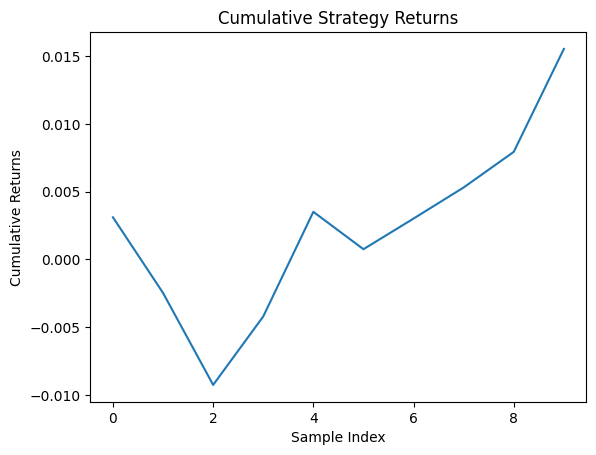

In [47]:
# Generate trading signals for the test set
signals = predict_batch(test)

# Get actual returns from the test set
returns = create_example_dataset(test)['target'].to_numpy()

# Calculate strategy returns
strategy_returns = signals * returns

# Calculate cumulative returns
cumulative_returns = np.cumsum(strategy_returns)

# Calculate annualized Sharpe ratio
sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
print(f"Strategy Sharpe Ratio: {sharpe:.2f}")

# Plot cumulative returns
import matplotlib.pyplot as plt
plt.plot(cumulative_returns)
plt.title("Cumulative Strategy Returns")
plt.xlabel("Sample Index")
plt.ylabel("Cumulative Returns")
plt.show()